# LeNet

In [18]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import re
from os.path import exists

In [19]:
import letter_detection_utils as ld_util
from importlib import reload 
import warnings

# Ensure we have always the latest state and 
# not the last import in memory
reload(ld_util)

<module 'letter_detection_utils' from '/Users/jpec/Prog/OCRpyMAN/notebooks/letter_detection/letter_detection_utils.py'>

In [20]:
img_size = (32, 128)
data = ld_util.get_dataframe_with_preprocessed_imgs(
    # pickle_name='ld_sobel_y', 
    img_size=img_size,
    with_edge_detection = False
)

df = data['df']
preprocessed_imgs = data['preprocessed_imgs']

print("Length: ", len(df))
print("Imgs length: ", len(preprocessed_imgs))
print("Img shape: ", preprocessed_imgs[0].shape)

Loading existing data from  ../../pickle/letter_detection_data.pickle ...
Length:  1000
Imgs length:  1000
Img shape:  (4096,)


# Model

In [21]:
from sklearn.model_selection import train_test_split


target = df['length'].to_numpy()
# We do not shuffle to have X_train[index] to match df[index]
X_train, X_test, y_train, y_test = train_test_split(preprocessed_imgs, target, test_size=0.2, shuffle=False)

In [22]:
X_train_lenet = X_train.reshape(-1, img_size[0], img_size[1], 1)
X_test_lenet = X_test.reshape(-1, img_size[0], img_size[1], 1)

X_train_lenet.shape

(800, 32, 128, 1)

In [23]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D 
from tensorflow.keras.layers import MaxPooling2D
from keras.utils import to_categorical

In [24]:
inputs = Input(shape=(X_train_lenet.shape[1], X_train_lenet.shape[2],  X_train_lenet.shape[3]))
conv_1 = Conv2D(filters = 32,                     # Nombre de filtres
                kernel_size = (5, 5),            # Dimensions du noyau
                padding = 'valid',               # Mode de Dépassement
                activation = 'relu')             # Fonction d'activation
max_pool_1 = MaxPooling2D(pool_size = (2, 2))
conv_2 = Conv2D(filters = 16,                    
                kernel_size = (3, 3),          
                padding = 'valid',             
                activation = 'relu')
max_pool_2 = MaxPooling2D(pool_size = (2, 2))
flatten = Flatten()
dropout = Dropout(rate = 0.2)
dense_1 = Dense(units = 128,
                activation = 'relu')
dense_2 = Dense(units = df['length'].max(),
                activation = 'softmax')

outputs=conv_1(inputs)
outputs=max_pool_1(outputs)
outputs=conv_2(outputs)
outputs=max_pool_2(outputs)
outputs=dropout(outputs)
outputs=flatten(outputs)
outputs=dense_1(outputs)
outputs=dense_2(outputs)

In [25]:
lenet = Model(inputs = inputs, outputs = outputs)

# Compilation
lenet.compile(loss='sparse_categorical_crossentropy',  # fonction de perte
              optimizer='adam',                 # algorithme de descente de gradient
              metrics=['accuracy'])             # métrique d'évaluation
nb_epochs = 16

training_history_lenet = lenet.fit(X_train_lenet, y_train,          # données
                                   validation_split = 0.2,    # split de test
                                   epochs = nb_epochs,               # nombre d'epochs
                                   batch_size = 20)          # taille des batchs

Train on 640 samples, validate on 160 samples
Epoch 1/16
640/640 [==============================] - 8s 12ms/sample - loss: 2.3115 - accuracy: 0.1719 - val_loss: 2.2293 - val_accuracy: 0.1813
Epoch 2/16
640/640 [==============================] - 6s 10ms/sample - loss: 2.2053 - accuracy: 0.2062 - val_loss: 2.1745 - val_accuracy: 0.1813
Epoch 3/16
640/640 [==============================] - 6s 10ms/sample - loss: 2.1559 - accuracy: 0.2266 - val_loss: 2.1483 - val_accuracy: 0.2188
Epoch 4/16
640/640 [==============================] - 6s 9ms/sample - loss: 2.0260 - accuracy: 0.3000 - val_loss: 2.0166 - val_accuracy: 0.2625
Epoch 5/16
640/640 [==============================] - 6s 10ms/sample - loss: 1.8884 - accuracy: 0.3422 - val_loss: 1.9721 - val_accuracy: 0.3313
Epoch 6/16
640/640 [==============================] - 6s 9ms/sample - loss: 1.7448 - accuracy: 0.4062 - val_loss: 1.9277 - val_accuracy: 0.3063
Epoch 7/16
640/640 [==============================] - 6s 10ms/sample - loss: 1.5900 - 

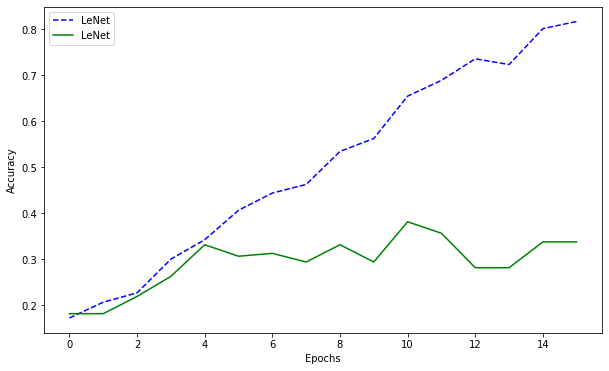

In [26]:
train_acc_lenet = training_history_lenet.history['accuracy']
val_acc_lenet = training_history_lenet.history['val_accuracy']

plt.figure(figsize=(10,6))
xaxis = range(nb_epochs)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(xaxis,
         train_acc_lenet, 
         label = 'LeNet',
         ls='--',
         color = 'blue')
plt.plot(xaxis,
         val_acc_lenet, 
         label = 'LeNet',
         color = 'green')
plt.legend()
plt.show()

In [27]:
y_pred_lenet = lenet.predict(X_test_lenet)

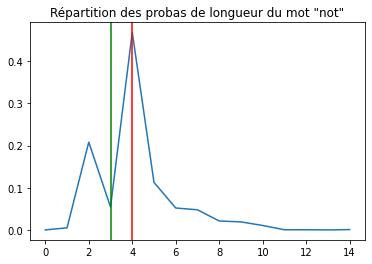

In [28]:
plt.plot(range(df['length'].max()), y_pred_lenet[0]);
plt.axvline(y_pred_lenet[0].argmax(), color='red');
plt.axvline(df.iloc[0 + 800].length, color='green');
plt.title('Répartition des probas de longueur du mot "' + df.iloc[0+ 800].transcription + '"');